In [1]:
# Necessary import statements
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
import nltk
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import HistGradientBoostingClassifier


## Data Loading and splitting

In [2]:
# Load the relevant data
radiology_data = pd.read_csv('../train/train_radiology.csv')
demographics_data = pd.read_csv('../train/train_demos.csv').set_index('patient_id')
sign_data = pd.read_csv('../train/train_signs.csv')
labels = pd.read_csv('../train/train_labels.csv').set_index('patient_id')

In [3]:
# Create a testing, training, and validation set based on the patient id
X_train, X_temp, Y_train, Y_temp = train_test_split(labels.index, labels['label'], test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

## Clustering

c:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


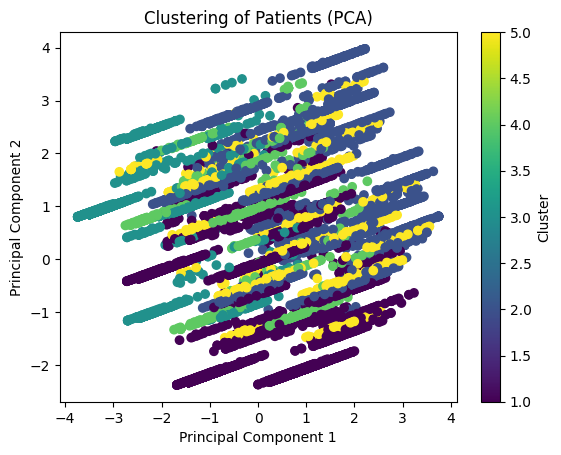

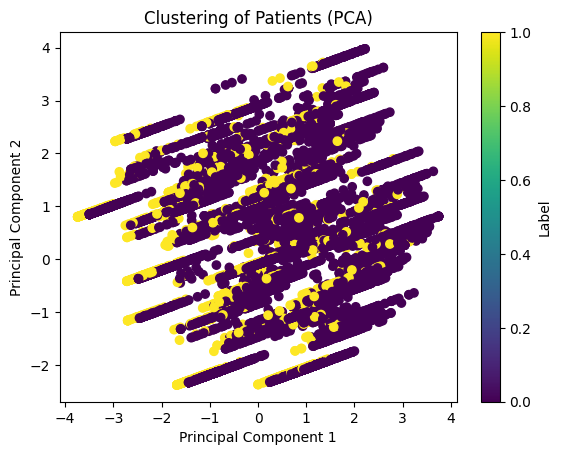

Percentage of each label value in each cluster:
label        0      1
cluster              
1        91.11   8.89
2        92.89   7.11
3        87.73  12.27
4        91.92   8.08
5        79.00  21.00
cluster
1    5724
2    4260
3    1785
4    1039
5     900
dtype: int64


In [4]:
clustering_data = demographics_data.merge(labels, left_index=True,right_on='patient_id')

df_clustering = clustering_data.drop(['admittime'], axis=1)

# Preprocess categorical variables 
df_clustering = pd.get_dummies(df_clustering, columns=['gender', 'insurance', 'marital_status', 'ethnicity'])

# Standardize numerical features
scaler = StandardScaler()
df_clustering_scaled = scaler.fit_transform(df_clustering)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=1)  # Reduce to 2 dimensions for visualization
df_pca = pca.fit_transform(df_clustering_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=6, random_state=1)  # Specify the number of clusters
clusters = kmeans.fit_predict(df_clustering_scaled)

# Count the number of samples in each cluster
cluster_counts = np.bincount(clusters)

# Specify the minimum cluster size
min_cluster_size = 100

# Find clusters with size less than the minimum
small_clusters = np.where(cluster_counts < min_cluster_size)[0]

# Merge small clusters into larger ones or discard them entirely
for small_cluster in small_clusters:
    # Example: Merge small clusters into the largest nearby cluster
    closest_cluster = np.argsort(np.linalg.norm(kmeans.cluster_centers_ - kmeans.cluster_centers_[small_cluster], axis=1))[1]
    clusters[clusters == small_cluster] = closest_cluster


# Add the cluster labels to the original DataFrame
clustering_data['cluster'] = clusters
clusters = clustering_data['cluster'].to_list()

# Visualize the clusters using the reduced-dimensional data
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clustering_data['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering of Patients (PCA)')
plt.colorbar(label='Cluster')
plt.show()

# Visualize the clusters using the reduced-dimensional data
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clustering_data['label'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering of Patients (PCA)')
plt.colorbar(label='Label')
plt.show()

# Group the DataFrame by 'cluster' and 'label', and count the occurrences
cluster_label_counts = clustering_data.groupby(['cluster', 'label']).size().unstack(fill_value=0)

# Calculate the total count of each label in each cluster
cluster_total_counts = cluster_label_counts.sum(axis=1)

# Calculate the percentage of each label value in each cluster
cluster_label_percentages = cluster_label_counts.div(cluster_total_counts, axis=0) * 100

print("Percentage of each label value in each cluster:")
print(np.round(cluster_label_percentages,2))

print(cluster_total_counts)

## Radiology Data Model Training

In [5]:
# Group radiology reports by patient_id and concatenate the text
radiology_data = radiology_data.groupby('patient_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
radiology_data['cluster'] = clusters

In [6]:
# Tokenization
radiology_data['tokenized_text'] = radiology_data['text'].apply(lambda x: word_tokenize(x.lower()))

In [7]:
# Data Preprocessing
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(tokens):
    tokens = [token for token in tokens if token.isalpha()]  # Remove punctuation
    tokens = [token for token in tokens if token not in stop_words]  # Remove stop words
    tokens = [ps.stem(token) for token in tokens]  # Stemming
    return tokens

In [8]:
radiology_data['tokenized_text'] = radiology_data['tokenized_text'].apply(preprocess_text)

In [9]:
# Merge radiology data with label data based on patient_id
radiology_data = pd.merge(radiology_data, labels, on='patient_id', how='left')

In [10]:
radiology_data.set_index('patient_id', inplace=True)

In [11]:
# Split data into features and labels
X_radiology = radiology_data['tokenized_text']
Y_radiology = radiology_data['label']

In [12]:
X_train_radiology = X_radiology.loc[X_train]
X_test_radiology = X_radiology.loc[X_test]
Y_train_radiology = Y_radiology.loc[Y_train.index]
Y_test_radiology = Y_radiology.loc[Y_test.index]

In [13]:
# Iterate over each cluster
cluster_list = radiology_data['cluster'].unique()
radiology_models = {}

for cluster in cluster_list:

    # Filter data for the current cluster
    X_train_cluster = X_train_radiology[radiology_data['cluster'] == cluster]
    y_train_cluster = Y_train_radiology[radiology_data['cluster'] == cluster]
    X_test_cluster = X_test_radiology[radiology_data['cluster'] == cluster]
    y_test_cluster = Y_test_radiology[radiology_data['cluster'] == cluster]    

    # Convert tokenized text into numerical features using Bag-of-Words
    vectorizer = CountVectorizer(max_features = 1024)
    X_train_bow = vectorizer.fit_transform(X_train_cluster.apply(lambda x: ' '.join(x)))
    X_test_bow = vectorizer.transform(X_test_cluster.apply(lambda x: ' '.join(x)))

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_bow, y_train_cluster)

    # Predict probabilities
    y_pred_proba = clf.predict_proba(X_test_bow)[:,1]
    y_pred = (y_pred_proba > 0.25).astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_cluster, y_pred)
    roc_auc = auc(fpr, tpr)

    radiology_models[cluster] = clf

    print("Cluster: " + str(cluster) + " - ROC: " + str(roc_auc))

Cluster: 1 - ROC: 0.5318675889328063
Cluster: 3 - ROC: 0.6379679144385028
Cluster: 4 - ROC: 0.5347222222222222
Cluster: 5 - ROC: 0.5240384615384616
Cluster: 2 - ROC: 0.5942411413327148


## Stats Model Training

In [14]:
# Calculate mean, min, and max for each vital sign for each patient
num_cols = sign_data.select_dtypes(include=[np.number]).columns
stats = sign_data.groupby("patient_id")[num_cols].agg(['mean','max','min'])
stats.columns = ['_'.join(col) for col in stats.columns]
stats['cluster'] = clusters
stats = pd.merge(stats, labels, on='patient_id', how='left')

In [15]:
X = stats.drop(columns=['cluster', 'label'])
Y = stats['label']

In [16]:
X_train_stats = X.loc[X_train]
X_test_stats = X.loc[X_test]
Y_train_stats = Y.loc[Y_train.index]
Y_test_stats = Y.loc[Y_test.index]

In [17]:
# Iterate over each cluster
clusters_list = stats['cluster'].unique()

stats_models = {}

for cluster in clusters_list:
    # Filter data for the current cluster
    X_train_cluster = X_train_stats[stats['cluster'] == cluster]
    y_train_cluster = Y_train_stats[stats['cluster'] == cluster]
    X_test_cluster = X_test_stats[stats['cluster'] == cluster]
    y_test_cluster = Y_test_stats[stats['cluster'] == cluster]    

    # Train classifier on the data
    classifier = HistGradientBoostingClassifier(random_state = 0)
    classifier.fit(X_train_cluster, y_train_cluster)

    # Predict probabilities
    y_pred_proba = classifier.predict_proba(X_test_cluster)[:,1]
    y_pred_probs = (y_pred_proba > 0.25).astype(int)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_cluster, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    stats_models[cluster] = classifier

    print("Cluster: " + str(cluster) + " - ROC: " + str(roc_auc))

C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cluster = X_train_stats[stats['cluster'] == cluster]
C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cluster = X_test_stats[stats['cluster'] == cluster]


Cluster: 1 - ROC: 0.6062252964426876


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cluster = X_train_stats[stats['cluster'] == cluster]
C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cluster = X_test_stats[stats['cluster'] == cluster]


Cluster: 3 - ROC: 0.5557932263814617


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cluster = X_train_stats[stats['cluster'] == cluster]
C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cluster = X_test_stats[stats['cluster'] == cluster]


Cluster: 4 - ROC: 0.6059027777777779


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cluster = X_train_stats[stats['cluster'] == cluster]
C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cluster = X_test_stats[stats['cluster'] == cluster]


Cluster: 5 - ROC: 0.8060897435897436


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_cluster = X_train_stats[stats['cluster'] == cluster]
C:\Users\steve\AppData\Local\Temp\ipykernel_24840\1876540310.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_cluster = X_test_stats[stats['cluster'] == cluster]


Cluster: 2 - ROC: 0.5676796381140173


## Validation Testing

#### Radiology Validation

In [18]:
X_val_set = radiology_data.loc[X_val]
X_val_set = X_val_set['tokenized_text']
Y_val_set = radiology_data.loc[X_val]['label']

Cluster Value: 1
0.5883556405353729


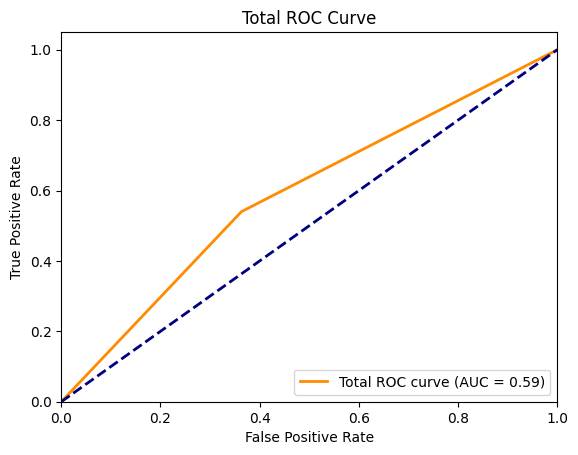

Cluster Value: 3
0.5187883435582822


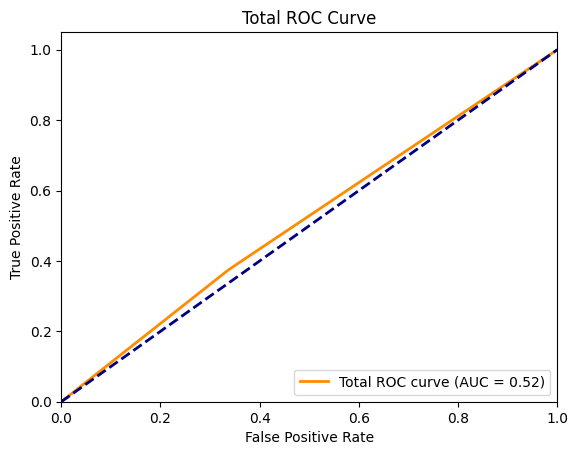

Cluster Value: 4
0.6280041797283177


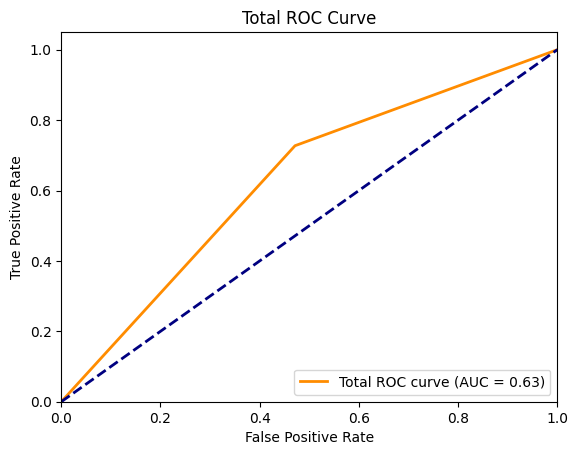

Cluster Value: 5
0.6928571428571428


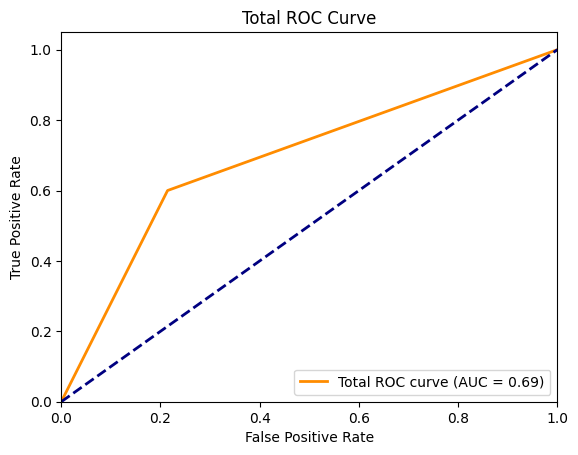

Cluster Value: 2
0.5471212121212121


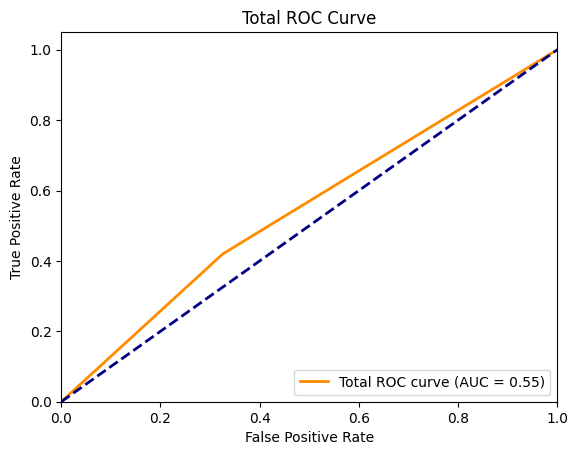

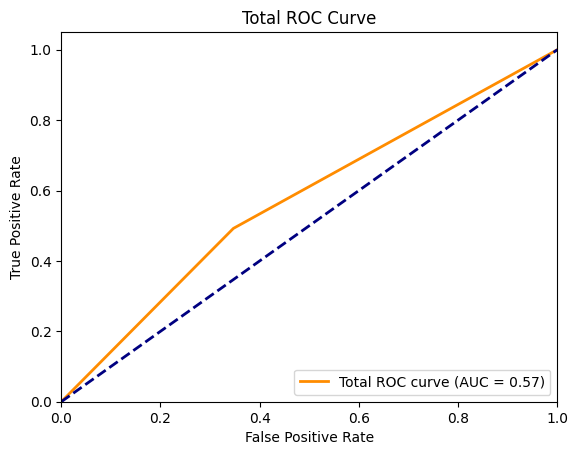

In [19]:
roc_values_val = []
total_labels = []
total_preds = []
y_val_radiology_probs = {}

for cluster_val in clusters_list:

    print("Cluster Value: " + str(cluster_val))

    X_cluster = X_val_set[radiology_data['cluster'] == cluster_val]
    Y_cluster = Y_val_set[radiology_data['cluster'] == cluster_val]

    X_cluster_vect = vectorizer.fit_transform(X_cluster.apply(lambda x: ' '.join(x)))

    # Predict probabilities
    y_pred_proba = radiology_models[cluster_val].predict_proba(X_cluster_vect)[:,1]
    y_val_radiology_probs[cluster_val] = y_pred_proba
    y_pred = (y_pred_proba > 0.25).astype(int)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y_cluster, y_pred)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)
    
    total_labels.extend(Y_cluster)
    total_preds.extend(y_pred)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Total ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_values_val.append(roc_auc)

fpr, tpr, _ = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Total ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Stats Validation

In [20]:
X_val_stats = X.loc[X_val]
Y_val_stats = Y.loc[Y_val.index]

1


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\3709798297.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_cluster = X_val_stats[stats['cluster'] == cluster]


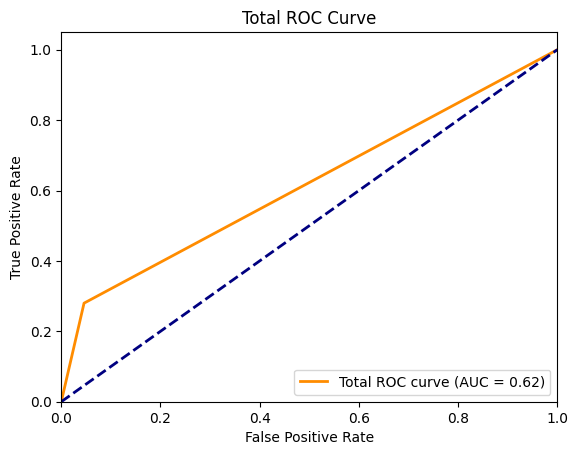

3


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\3709798297.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_cluster = X_val_stats[stats['cluster'] == cluster]


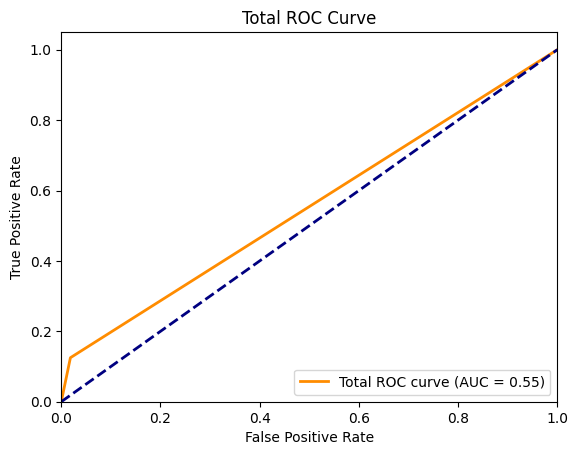

4


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\3709798297.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_cluster = X_val_stats[stats['cluster'] == cluster]


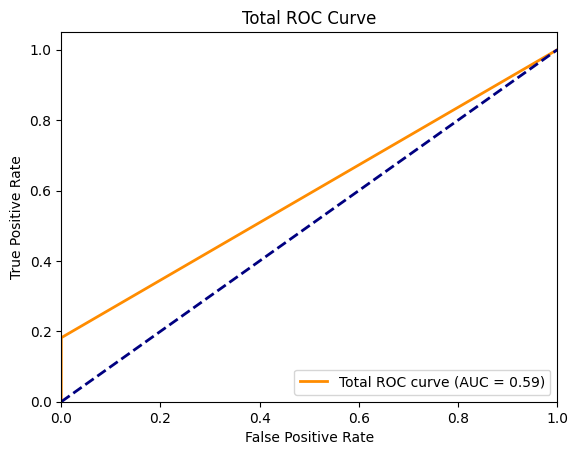

5


C:\Users\steve\AppData\Local\Temp\ipykernel_24840\3709798297.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_cluster = X_val_stats[stats['cluster'] == cluster]


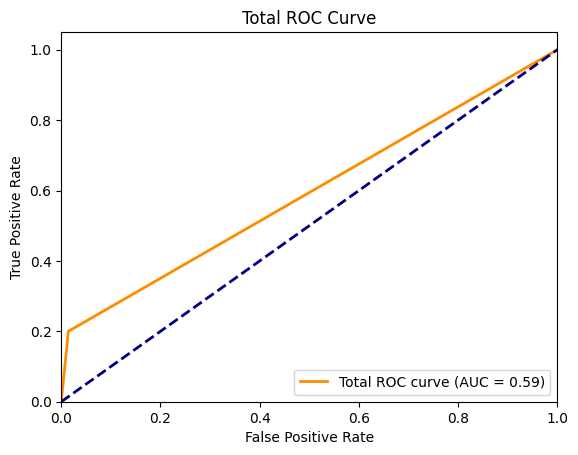

C:\Users\steve\AppData\Local\Temp\ipykernel_24840\3709798297.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_cluster = X_val_stats[stats['cluster'] == cluster]


2


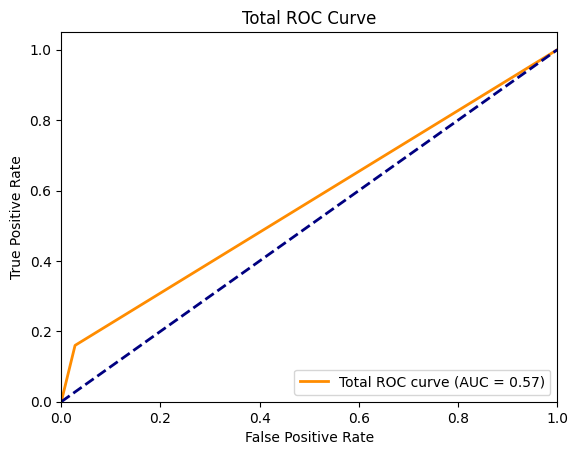

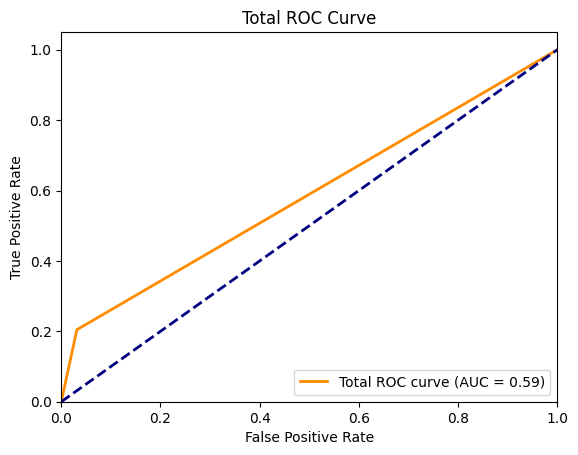

In [21]:
roc_values_val = []

y_val_stats_probs = {}
y_val_labels = {}

total_labels = []
total_preds = []

for cluster in clusters_list:

    print(cluster)

    X_cluster = X_val_stats[stats['cluster'] == cluster]
    Y_cluster = Y_val_stats[stats['cluster'] == cluster]

    # Predict probabilities
    y_pred_proba = stats_models[cluster].predict_proba(X_cluster)[:,1]
    y_val_stats_probs[cluster] = y_pred_proba
    y_val_labels[cluster] = Y_cluster
    
    y_pred = (y_pred_proba > 0.25).astype(int)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(Y_cluster, y_pred)
    roc_auc = auc(fpr, tpr)

    total_labels.extend(Y_cluster)
    total_preds.extend(y_pred)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Total ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    roc_values_val.append(roc_auc)

fpr, tpr, _ = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Total ROC Curve')
plt.legend(loc="lower right")
plt.show()

Cluster Value: 1
0.6559273422562142


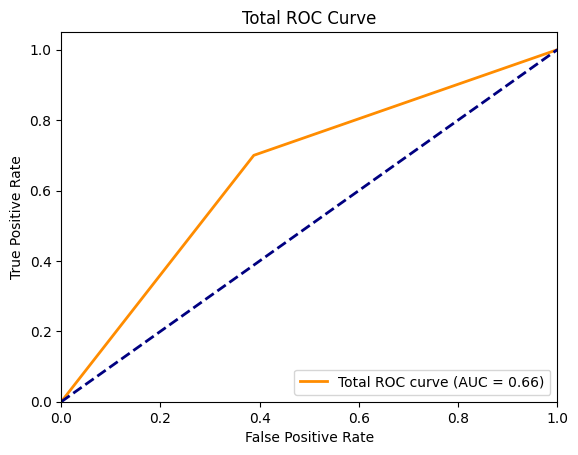

Cluster Value: 3
0.5439033742331288


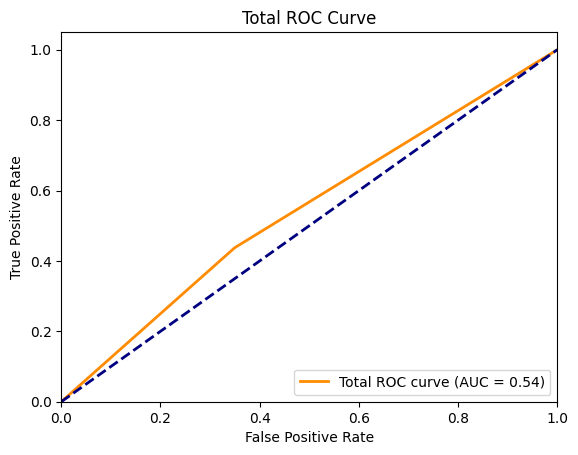

Cluster Value: 4
0.6280041797283177


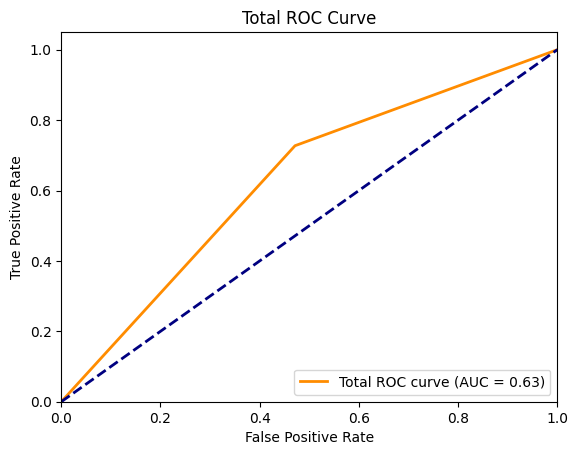

Cluster Value: 5
0.7857142857142857


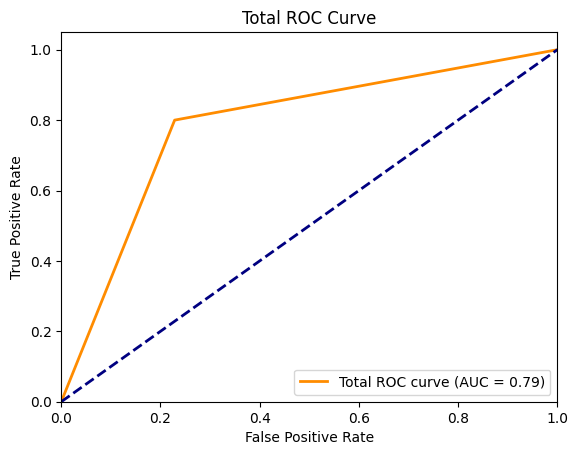

Cluster Value: 2
0.5595454545454546


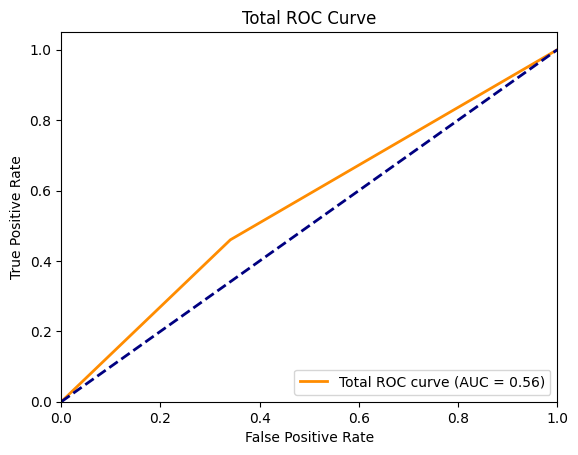

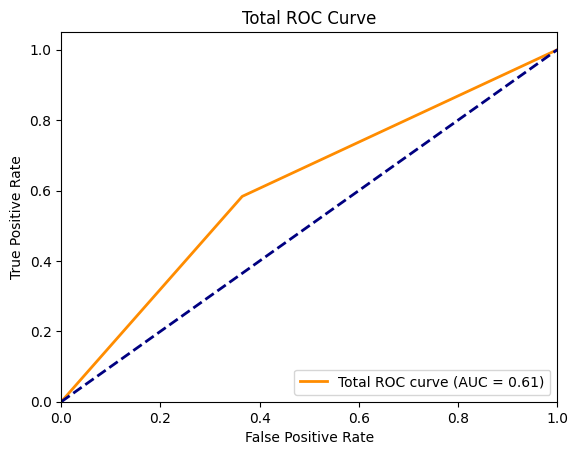

In [22]:
total_labels = []
total_preds = []

for cluster_val in y_val_stats_probs.keys():
    print("Cluster Value: " + str(cluster_val))
    average = np.maximum(np.array(y_val_stats_probs[cluster_val]),np.array(y_val_radiology_probs[cluster_val]))
    average = (average > 0.25).astype(int)
    fpr, tpr, _ = roc_curve(y_val_labels[cluster_val], average)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    total_labels.extend(y_val_labels[cluster_val])
    total_preds.extend(average)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Total ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

fpr, tpr, _ = roc_curve(total_labels, total_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Total ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Total ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Test Answers Generation

In [23]:
# Load the relevant data
radiology_data_test = pd.read_csv('../test/test_radiology.csv')
demographics_data_test = pd.read_csv('../test/test_demos.csv').set_index('patient_id')
sign_data_test = pd.read_csv('../test/test_signs.csv')

c:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


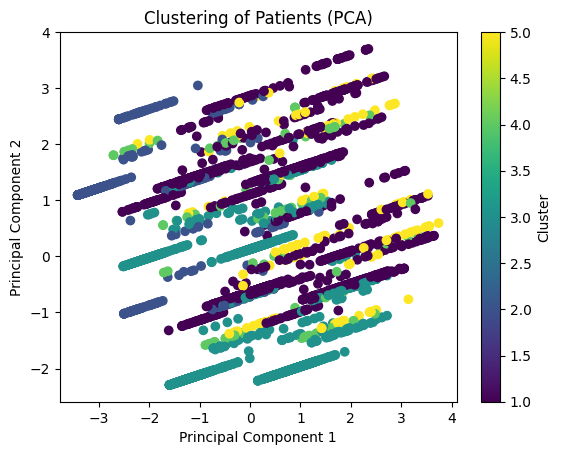

Percentage of each label value in each cluster:
cluster
1    40.30
2    12.49
3    39.77
4     3.18
5     4.26
dtype: float64
3427


In [24]:
clustering_data_test = demographics_data_test.drop(['admittime'], axis=1)
df_clustering_test = clustering_data_test

# Preprocess categorical variables 
df_clustering_test = pd.get_dummies(df_clustering_test, columns=['gender', 'insurance', 'marital_status', 'ethnicity'])

# Standardize numerical features
df_clustering_scaled_test = scaler.fit_transform(df_clustering_test)

# Apply PCA for dimensionality reduction
df_pca_test = pca.fit_transform(df_clustering_scaled_test)

# Apply K-means clustering
clusters_test = kmeans.fit_predict(df_clustering_scaled_test)

# Count the number of samples in each cluster
cluster_counts = np.bincount(clusters_test)

# Specify the minimum cluster size
min_cluster_size = 100

# Find clusters with size less than the minimum
small_clusters = np.where(cluster_counts < min_cluster_size)[0]

# Merge small clusters into larger ones or discard them entirely
for small_cluster in small_clusters:
    # Example: Merge small clusters into the largest nearby cluster
    closest_cluster = np.argsort(np.linalg.norm(kmeans.cluster_centers_ - kmeans.cluster_centers_[small_cluster], axis=1))[1]
    clusters_test[clusters_test == small_cluster] = closest_cluster

# Add the cluster labels to the original DataFrame
clustering_data_test['cluster'] = clusters_test

# Concatenate labels with label 0 into label 1
clustering_data_test['cluster'].replace({0: 1}, inplace=True)

clusters_test = clustering_data_test['cluster'].to_list()

# Visualize the clusters using the reduced-dimensional data
plt.scatter(df_pca_test[:, 0], df_pca_test[:, 1], c=clustering_data_test['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clustering of Patients (PCA)')
plt.colorbar(label='Cluster')
plt.show()

# Group the DataFrame by 'cluster' and 'label', and count the occurrences
cluster_label_counts = clustering_data_test.groupby(['cluster']).size()

# Calculate the total count of each label in each cluster
cluster_total_counts = cluster_label_counts.sum()

# Calculate the percentage of each label value in each cluster
cluster_label_percentages = cluster_label_counts.div(cluster_total_counts, axis=0) * 100

print("Percentage of each label value in each cluster:")
print(np.round(cluster_label_percentages,2))

print(cluster_total_counts)

In [25]:
# Calculate mean, min, and max for each vital sign for each patient
num_cols = sign_data_test.select_dtypes(include=[np.number]).columns
stats_test = sign_data_test.groupby("patient_id")[num_cols].agg(['mean','max','min'])
stats_test.columns = ['_'.join(col) for col in stats_test.columns]
stats_test['cluster'] = clusters_test

In [26]:
# Group radiology reports by patient_id and concatenate the text
radiology_data_test = radiology_data_test.groupby('patient_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
radiology_data_test['cluster'] = clusters_test
radiology_data_test['tokenized_text'] = radiology_data_test['text'].apply(lambda x: word_tokenize(x.lower()))

In [ ]:
radiology_data_test['tokenized_text'] = radiology_data_test['tokenized_text'].apply(preprocess_text)

In [ ]:
radiology_data_test.set_index('patient_id', inplace=True)


In [ ]:
# Split data into features and labels
X_radiology_test = radiology_data_test['tokenized_text']
X_stats_test = stats_test.drop(columns=['cluster'])

In [ ]:
import csv

with open('test_labels.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header row
    writer.writerow(['patient_id', 'probability'])


clusters_list = clustering_data_test['cluster'].unique()

for cluster_val in clusters_list:

    X_cluster_test_radiology = X_radiology_test[radiology_data_test['cluster'] == cluster_val]
    X_cluster_test_stats = X_stats_test[stats_test['cluster'] == cluster_val]

    X_cluster_vect_test = vectorizer.fit_transform(X_cluster_test_radiology.apply(lambda x: ' '.join(x)))

    # Predict probabilities
    y_pred_proba_radiology_test = radiology_models[cluster_val].predict_proba(X_cluster_vect_test)[:,1]
    y_pred_proba_stats_test = stats_models[cluster_val].predict_proba(X_cluster_test_stats)[:,1]
    max_between = np.maximum(np.array(y_pred_proba_stats_test),np.array(y_pred_proba_radiology_test))

    clusterDF = pd.DataFrame(X_cluster_test_radiology).reset_index()
    clusterDF['prediction'] = max_between
    clusterDF = clusterDF[['patient_id','prediction']]

    clusterDF.to_csv('test_labels.csv', mode='a', index=False)